In [9]:
import matplotlib.pyplot as plt
from pytorch_lightning.metrics.functional import accuracy, precision_recall, f1
import seaborn as sn
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

from model import GarbageModel
from util import make_ensemble

In [10]:
model_paths = [
    "logs_cutmix/version_5/checkpoints/epoch=199-step=1599.ckpt",
    "logs_cutmix/version_6/checkpoints/epoch=199-step=1599.ckpt",
    # "lightning_logs/version_1/checkpoints/epoch=129-step=25479.ckpt",
    # "lightning_logs/version_3/checkpoints/epoch=129-step=25479.ckpt",
]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device : {}".format(device))
model = make_ensemble(model_paths, GarbageModel, device)

Device : cuda:0
 * Loading ensemble ...
Adding logs_cutmix/version_5/checkpoints/epoch=199-step=1599.ckpt
Adding logs_cutmix/version_6/checkpoints/epoch=199-step=1599.ckpt
Categories : ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Input Size : 224
 * Ensemble loaded.


In [11]:
root = "data/test448"
batch_size = 32

valid_transform = T.Compose([
    T.Resize(model.input_size),
    T.CenterCrop(model.input_size),
    T.ToTensor(),
])
valid_ds = ImageFolder(root=root, transform=valid_transform)
num_classes = len(valid_ds.classes)
val_loader = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=True, num_workers=0)
print("{} Test Samples.".format(len(valid_ds)))

180 Test Samples.


In [12]:
yhats = []  # All model predictions
ensemble = []  # Mean prediction
targets = []  # Targets
for i, (data, target) in enumerate(val_loader):
    data = data.to(device)
    # yhat = model(data)  # Enemble forward pass
    yhat = [torch.softmax(m(data.clone()), dim=1) for m in model.models]
    avg_pred = torch.mean(torch.stack(yhat), dim=0)
    yhat = torch.stack([torch.argmax(y, dim=1) for y in yhat])
    yhats.append(yhat)
    ensemble.append(avg_pred)
    targets.append(target)
    # if i > 1000: break
preds = torch.cat(yhats, dim=1).cpu()
pred = torch.argmax(torch.cat(ensemble), dim=1).cpu()
target = torch.cat(targets).cpu()
print("preds.shape :", preds.shape)
print("pred.shape :", pred.shape)
print("target.shape :", target.shape)


preds.shape : torch.Size([2, 180])
pred.shape : torch.Size([180])
target.shape : torch.Size([180])


In [13]:
def stats(pred, target):
    acc = accuracy(pred, target)
    avg_precision, avg_recall = precision_recall(pred, target, num_classes=num_classes, average="macro", mdmc_average="global")
    weighted_f1 = f1(pred, target, num_classes=num_classes, threshold=0.5, average="weighted")
    return 100*acc, 100*avg_precision, 100*avg_recall, 100*weighted_f1

headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
width = max(len(cn) for cn in headers)
head_fmt = ' {:>9}'*len(headers) + '\n'
stat_str = head_fmt.format(*headers, width=width)
for i in range(len(model.models)):
    row = stats(preds[i, :], target)
    row_fmt = '{:>{width}s} ' + ' {:>9.2f}'*(len(headers)-1) + '\n'
    stat_str += row_fmt.format(str(i), *row, width=width)
row = stats(pred, target)
row_fmt = '{:>{width}s} ' + ' {:>9.2f}'*(len(headers)-1) + '\n'
stat_str += row_fmt.format("Ensemble", *row, width=width)
print(stat_str)

     Model  Accuracy Precision    Recall  F1 Score
        0      83.33     84.46     83.33     83.10
        1      86.11     87.66     86.11     86.11
 Ensemble      87.22     88.97     87.22     87.16



In [14]:
from sklearn.metrics import classification_report
print( classification_report(target, pred, target_names=model.classes, digits=4) )

              precision    recall  f1-score   support

   cardboard     0.9667    0.9667    0.9667        30
       glass     0.6512    0.9333    0.7671        30
       metal     0.9355    0.9667    0.9508        30
       paper     1.0000    1.0000    1.0000        30
     plastic     0.9048    0.6333    0.7451        30
       trash     0.8800    0.7333    0.8000        30

    accuracy                         0.8722       180
   macro avg     0.8897    0.8722    0.8716       180
weighted avg     0.8897    0.8722    0.8716       180



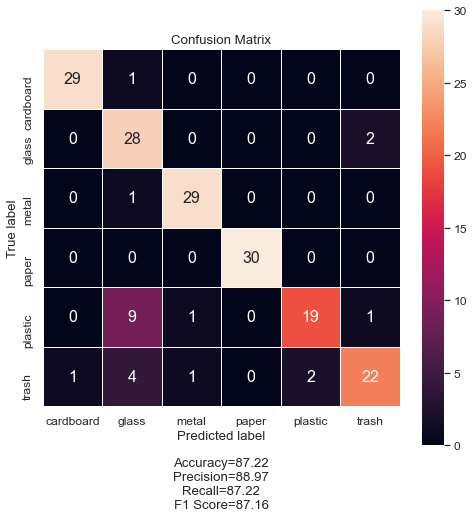

In [15]:
cm = confusion_matrix(target, pred)
plt.figure(figsize=(8, 8))
sn.set(font_scale=1.1)  # Label size
sn.heatmap(cm, annot=True, fmt="d",
# cmap='Blues',
# cbar=False,
vmin=0, xticklabels=model.classes,  yticklabels=model.classes, annot_kws={"size": 16}, square=True, linewidths=0.5)
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label\n\nAccuracy={:.2f}\nPrecision={:.2f}\nRecall={:.2f}\nF1 Score={:.2f}'.format(*row))
plt.show()